<a href="https://colab.research.google.com/github/nikiduki/ts_ml/blob/master/trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install yfinance
!pip install catboost
!pip install optuna
import optuna
import catboost
import lightgbm as lgb
import numpy as np
import yfinance as yf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


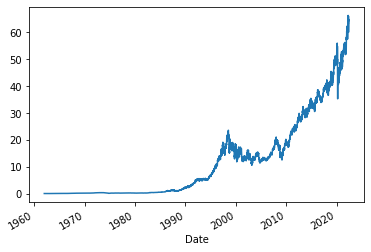

In [34]:
tickerSymbol = 'KO'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='max')

tickerDf.Close.plot()

In [35]:
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1962-01-02,0.050745,0.052126,0.050745,0.050745,806400,0.0,0.0
1962-01-03,0.049991,0.049991,0.048860,0.049614,1574400,0.0,0.0
1962-01-04,0.049740,0.050368,0.049740,0.049991,844800,0.0,0.0
1962-01-05,0.049991,0.050619,0.048735,0.048860,1420800,0.0,0.0
1962-01-08,0.048484,0.048484,0.047416,0.048358,2035200,0.0,0.0


In [36]:
del_columns = {'Volume', 'Dividends', 'Stock Splits'}
for col in del_columns:
  tickerDf = tickerDf.drop(col, axis=1)

tickerDf.head()

,Open,High,Low,Close
Date,,,,
1962-01-02,0.050745,0.052126,0.050745,0.050745
1962-01-03,0.049991,0.049991,0.048860,0.049614
1962-01-04,0.049740,0.050368,0.049740,0.049991
1962-01-05,0.049991,0.050619,0.048735,0.048860
1962-01-08,0.048484,0.048484,0.047416,0.048358


In [37]:
def get_columns(data, columns_data, col_shift, size_table=10):
  for i in range(1, size_table+1):
    col_name = f'shift_{col_shift}_{i}'
    data[col_name] = data[col_shift].shift(i)
    columns_data.append(col_name)
  data = data.dropna()
  return data

In [38]:
def get_features(data, col_pred):
  columns_data = [f'{col_pred}_pct_change']
  for column in data.columns:
    data[f'{column}_pct_change'] = data[column].pct_change()
    col_shift = f'{column}_pct_change'
    data = get_columns(data, columns_data, col_shift, size_table=10)
    if column!=col_pred:
      data = data.drop(column, axis=1)
      data = data.drop(f'{column}_pct_change', axis=1)
  X = data[columns_data[1:]].values
  y = data[columns_data[0]].values.reshape(-1, 1)
  display(data)
  return X, y

In [39]:
def un_pct_change(diff, orig):
  un_pct_change = (orig.shift(1) * diff.ravel()) + orig.shift(1)
  return un_pct_change[1:]

In [40]:
def metrics(pred, target):
  mse = mean_squared_error(pred, target)
  mae = mean_absolute_error(pred, target)
  mape = mean_absolute_percentage_error(pred, target)
  return mse, mae, mape

In [41]:
def objectives_ridge(trial):
  alpha = trial.suggest_uniform('alpha', 0.0, 0.05)
  model = Ridge(alpha=alpha)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [42]:
def objectives_lasso(trial):
  alpha = trial.suggest_uniform('alpha', 0.0, 0.1)
  model = Lasso(alpha=alpha)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [43]:
def objectives_cb(trial):
  params_cb = {
                "subsample": trial.suggest_float("subsample", 0.5, 0.99),
                'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.99),
                "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0),
                "max_depth": trial.suggest_int("max_depth", 4, 10, step=1),
                "n_estimators": trial.suggest_int("n_estimators", 100, 2500, step=1),
                'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                'random_state': 0,
                'loss_function': 'MAE', 
                'eval_metric': 'MAE', 
                'one_hot_max_size': 0,
                'boost_from_average': True
              }
  model = catboost.CatBoostRegressor(**params_cb)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [44]:
def objectives_lgb(trial):
  params_lgb = {
            'num_leaves': trial.suggest_int('num_leaves', 200, 3000),
            'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
            'max_bin': trial.suggest_int('max_bin', 2, 100),
            'learning_rate': trial.suggest_uniform('learning_rate',0, 1),
                  }
  model = lgb.LGBMRegressor(**params_lgb)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE         

In [45]:
def objectives_rf(trial):
  params_rf = {
          'max_depth' : trial.suggest_int('max_depth', 1, 500),
          'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']),
          'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 1, 1000),
          'n_estimators' :  trial.suggest_int('n_estimators', 30, 1000)
            }

  model = RandomForestRegressor(**params_rf)
  model.fit(X_train, y_train.ravel())
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE         

In [46]:
def objectives_dtr(trial):
  params_dtr = {
            "splitter": trial.suggest_categorical("splitter", ["best","random"]),
            "max_depth" : trial.suggest_int("max_depth", 1, 12),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
            "min_weight_fraction_leaf" : trial.suggest_uniform("min_weight_fraction_leaf", 0.05, 0.5),
            "max_features" : trial.suggest_categorical("max_features", ["auto","log2","sqrt",None]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes", 10, 90, 10)
            }
  model = DecisionTreeRegressor(**params_dtr)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [47]:
def objectives_reg(trial):
  params_reg = {}
  model = LinearRegression(**params_reg)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [48]:
optuna_objectives = {
                     'LinearRegression' : objectives_reg,
                     'LinearRegression_ridge' : objectives_ridge,
                     'LinearRegression_lasso' : objectives_lasso,
                     'CatBoostRegressor' : objectives_cb,
                     'DecisionTreeRegressor' : objectives_dtr,
                     'LGBMRegressor' : objectives_lgb,
                     'RandomForestRegressor' : objectives_rf
                     }
params_models_High = {
                    'LinearRegression' : {},
                    'LinearRegression_ridge' : {'alpha': 0.005913721293446661},
                    'LinearRegression_lasso' : {'alpha': 0.05488135039273248},
                    'CatBoostRegressor' : {'subsample': 0.71089719535895, 'od_wait': 30, 'colsample_bylevel': 0.7627269724046915, 'random_strength': 7, 'l2_leaf_reg': 14.602208788856538, 'max_depth': 4, 'n_estimators': 1042, 'learning_rate': 0.08775715546881825},
                    'DecisionTreeRegressor' : {'splitter': 'best', 'max_depth': 8, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.13846206275602407, 'max_features': None, 'max_leaf_nodes': 10},
                    'LGBMRegressor' : {'num_leaves': 1842, 'n_estimators': 158, 'max_bin': 84, 'learning_rate': 0.004695476192547066},
                    'RandomForestRegressor' : {'max_depth': 104, 'max_features': 'log2', 'max_leaf_nodes': 278, 'n_estimators': 599}
                } 
params_models_Low = {
                    'LinearRegression' : {},
                    'LinearRegression_ridge' : {'alpha': 0.0071676643704523205},
                    'LinearRegression_lasso' : {'alpha': 0.05488135039273248},
                    'CatBoostRegressor' : {'subsample': 0.6995481739927656, 'od_wait': 19, 'colsample_bylevel': 0.5649189410314117, 'random_strength': 1, 'l2_leaf_reg': 36.55412384631836, 'max_depth': 4, 'n_estimators': 1950, 'learning_rate': 0.007765188411856369},
                    'DecisionTreeRegressor' : {'splitter': 'best', 'max_depth': 8, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.05929294975957791, 'max_features': 'auto', 'max_leaf_nodes': 80},
                    'LGBMRegressor' : {'num_leaves': 1842, 'n_estimators': 158, 'max_bin': 84, 'learning_rate': 0.004695476192547066},
                    'RandomForestRegressor' : {'max_depth': 390, 'max_features': 'sqrt', 'max_leaf_nodes': 462, 'n_estimators': 787}
                }      
params_models_default = {
                    'LinearRegression' : {},
                    'LinearRegression_ridge' : {},
                    'LinearRegression_lasso' : {},
                    'CatBoostRegressor' : {},
                    'DecisionTreeRegressor' : {},
                    'LGBMRegressor' : {},
                    'RandomForestRegressor' : {}
                }                  
params_models = {
                  'High': params_models_High,
                  'Low': params_models_Low,
                  'Close': params_models_default,
                  'Open': params_models_default
                }
models = {
          'LinearRegression' : LinearRegression,
          'LinearRegression_ridge' : Ridge, 
          'LinearRegression_lasso' : Lasso, 
          'DecisionTreeRegressor' : DecisionTreeRegressor, 
          'RandomForestRegressor' : RandomForestRegressor, 
          'LGBMRegressor' : lgb.LGBMRegressor,
          'CatBoostRegressor' : catboost.CatBoostRegressor
          }

In [49]:
def pipeline(model_name, data_df, col_pred, train=False, n_optuna=None, metrics_flag=False):
  data = data_df.copy()
  X, y = get_features(data, col_pred)
  global X_train, y_train, X_test, y_test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=42)

  # optuna
  if n_optuna is None:
    model = models[model_name](**params_models[col_pred][model_name])
  else:
    opt = optuna.create_study(direction='minimize',sampler=optuna.samplers.RandomSampler(seed=0))
    opt.optimize(optuna_objectives[model_name], n_trials=n_optuna)
    trial = opt.best_trial
    params_best = dict(trial.params.items())     
    model = models[model_name](**params_best) 

  model.fit(X_train, y_train)
  if train:
    pred = model.predict(X_train)
    un_pct_change_pred = un_pct_change(pred, data[col_pred][len(data) - len(pred):])
    un_pct_change_target = un_pct_change(y_train, data[col_pred][len(data) - len(pred):])
  else:
    pred = model.predict(X_test)
    un_pct_change_pred = un_pct_change(pred, data[col_pred][len(data) - len(pred):])
    un_pct_change_target = un_pct_change(y_test, data[col_pred][len(data) - len(pred):])
  if metrics_flag:
    mse, mae, mape = metrics(un_pct_change_pred, un_pct_change_target)
    print('\n-----------------------------------------------'
        f'\nMetrics of prediction {col_pred} of {model_name}:\n'
        f'\n\tMSE = {mse}'
        f'\n\tMAE = {mae}'
        f'\n\tMAPE = {mape}')

  return un_pct_change_pred

In [50]:
def trading(preds_high, preds_low, target_high, target_low, target_close, L=1):
  profit = 0
  pos = False
  num_steps = len(target_close)
  success_deals = 0
  failed_deals = 0
  deals = []
  commission = 0
  for step in range(num_steps):
    buy_price = preds_low[step] / L
    sell_price = preds_high[step] * L
    if buy_price >= target_low[step]:
      pos = True
      profit -= commission / 100 * buy_price
    if pos:
      if sell_price <= target_high[step]:
        p = sell_price - buy_price
        success_deals += 1
        status = 'success'
      else:
        sell_price = target_close[step]
        p = sell_price - buy_price
        failed_deals += 1
        status = 'failed'
      profit += p
      pos = False
      deals.append({
        'status' : status,
        'buy_price' : buy_price,
        'sell_price' : sell_price,
        'profit' : p,
        'total_profit' : profit,
        'success_deals' : success_deals,
        'failed_deals' : failed_deals
      })
  return deals

In [51]:
preds = {
         'High': pd.DataFrame(),
         'Low': pd.DataFrame()
        }
for col in preds.keys():
  for name_model in models.keys():
    print(f'\n---------------------------{name_model}---------------------------\n')
    preds[col][name_model] = pipeline(name_model, tickerDf, col, n_optuna=None, metrics_flag=True)
  preds[col][col] = tickerDf[col][(len(tickerDf[col]) - len(y_test))+1:]


---------------------------LinearRegression---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction High of LinearRegression:

	MSE = 0.07885096699571185
	MAE = 0.16550608522041907
	MAPE = 0.005912862367065474

---------------------------LinearRegression_ridge---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction High of LinearRegression_ridge:

	MSE = 0.07846951788169677
	MAE = 0.16589458948190983
	MAPE = 0.005924038257097104

---------------------------LinearRegression_lasso---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction High of LinearRegression_lasso:

	MSE = 0.10411858356820977
	MAE = 0.19091958308675452
	MAPE = 0.006824982167595321

---------------------------DecisionTreeRegressor---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction High of DecisionTreeRegressor:

	MSE = 0.09609554428153709
	MAE = 0.18810452397385166
	MAPE = 0.00667263053577418

---------------------------RandomForestRegressor---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



-----------------------------------------------
Metrics of prediction High of RandomForestRegressor:

	MSE = 0.08666936649909977
	MAE = 0.17708169426400833
	MAPE = 0.006289035772937861

---------------------------LGBMRegressor---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



-----------------------------------------------
Metrics of prediction High of LGBMRegressor:

	MSE = 0.08643335176527596
	MAE = 0.1753411482780472
	MAPE = 0.006255652664282824

---------------------------CatBoostRegressor---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


0:	learn: 0.0137852	total: 5.7ms	remaining: 5.93s
1:	learn: 0.0136441	total: 19.5ms	remaining: 10.1s
2:	learn: 0.0135207	total: 28.7ms	remaining: 9.94s
3:	learn: 0.0133544	total: 34ms	remaining: 8.82s
4:	learn: 0.0132615	total: 39.3ms	remaining: 8.15s
5:	learn: 0.0131845	total: 44.8ms	remaining: 7.74s
6:	learn: 0.0131168	total: 50.3ms	remaining: 7.43s
7:	learn: 0.0130391	total: 55.8ms	remaining: 7.21s
8:	learn: 0.0129931	total: 61.2ms	remaining: 7.02s
9:	learn: 0.0129340	total: 66.6ms	remaining: 6.88s
10:	learn: 0.0128888	total: 72.1ms	remaining: 6.76s
11:	learn: 0.0128412	total: 77.3ms	remaining: 6.63s
12:	learn: 0.0128031	total: 85.5ms	remaining: 6.77s
13:	learn: 0.0127736	total: 90.9ms	remaining: 6.67s
14:	learn: 0.0127402	total: 96.3ms	remaining: 6.6s
15:	learn: 0.0126948	total: 102ms	remaining: 6.53s
16:	learn: 0.0126930	total: 107ms	remaining: 6.47s
17:	learn: 0.0126655	total: 112ms	remaining: 6.4s
18:	learn: 0.0126390	total: 118ms	remaining: 6.36s
19:	learn: 0.0126134	total: 124

,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction Low of LinearRegression:

	MSE = 0.09878656907255108
	MAE = 0.17191586207883622
	MAPE = 0.006121398503913286

---------------------------LinearRegression_ridge---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction Low of LinearRegression_ridge:

	MSE = 0.09803255312018147
	MAE = 0.17200454174831867
	MAPE = 0.006118100136010354

---------------------------LinearRegression_lasso---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction Low of LinearRegression_lasso:

	MSE = 0.12448951416154898
	MAE = 0.19973613228179316
	MAPE = 0.007213210360391252

---------------------------DecisionTreeRegressor---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction Low of DecisionTreeRegressor:

	MSE = 0.11547591021162741
	MAE = 0.19112669024776327
	MAPE = 0.006827064877119111

---------------------------RandomForestRegressor---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



-----------------------------------------------
Metrics of prediction Low of RandomForestRegressor:

	MSE = 0.11504456271253227
	MAE = 0.18284284264415507
	MAPE = 0.006500211296763293

---------------------------LGBMRegressor---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



-----------------------------------------------
Metrics of prediction Low of LGBMRegressor:

	MSE = 0.10848806833196098
	MAE = 0.18119960356770765
	MAPE = 0.006485160630512608

---------------------------CatBoostRegressor---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,0.008090,...,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,-0.005347,...,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005380,...,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810,-0.005380
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397,-0.010810
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013549,0.010958,-0.005450,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


0:	learn: 0.0151462	total: 4.58ms	remaining: 8.92s
1:	learn: 0.0151234	total: 9.53ms	remaining: 9.28s
2:	learn: 0.0151000	total: 13.8ms	remaining: 8.93s
3:	learn: 0.0150819	total: 18.1ms	remaining: 8.81s
4:	learn: 0.0150595	total: 22.4ms	remaining: 8.72s
5:	learn: 0.0150362	total: 28.9ms	remaining: 9.35s
6:	learn: 0.0150129	total: 33.3ms	remaining: 9.24s
7:	learn: 0.0149900	total: 37.7ms	remaining: 9.16s
8:	learn: 0.0149714	total: 42.2ms	remaining: 9.11s
9:	learn: 0.0149493	total: 47.1ms	remaining: 9.13s
10:	learn: 0.0149283	total: 51.7ms	remaining: 9.11s
11:	learn: 0.0149099	total: 56.1ms	remaining: 9.07s
12:	learn: 0.0148892	total: 60.5ms	remaining: 9.02s
13:	learn: 0.0148700	total: 64.8ms	remaining: 8.96s
14:	learn: 0.0148538	total: 68.9ms	remaining: 8.88s
15:	learn: 0.0148468	total: 73.1ms	remaining: 8.84s
16:	learn: 0.0148260	total: 77.4ms	remaining: 8.8s
17:	learn: 0.0148079	total: 82ms	remaining: 8.8s
18:	learn: 0.0147897	total: 86.7ms	remaining: 8.81s
19:	learn: 0.0147754	total

In [52]:
for df in preds.values():
  display(df)

,LinearRegression,LinearRegression_ridge,LinearRegression_lasso,DecisionTreeRegressor,RandomForestRegressor,LGBMRegressor,CatBoostRegressor,High
Date,,,,,,,,
2002-07-17,14.409089,14.393593,14.585149,14.441864,14.429829,14.499483,14.330413,14.645933
2002-07-18,14.416624,14.439487,14.655667,14.638398,14.644197,14.611070,14.680248,14.197677
2002-07-19,13.856871,13.884783,14.207113,14.067542,13.968198,13.942893,13.982163,13.306800
2002-07-22,13.077931,13.088237,13.315644,13.184830,13.128353,13.238366,12.958227,13.334993
2002-07-23,13.389540,13.403265,13.343856,13.449016,13.576646,13.392848,13.491684,12.962859
...,...,...,...,...,...,...,...,...
2022-05-23,61.787285,61.805154,61.280701,61.763643,61.652772,61.478557,61.806336,63.099998
2022-05-24,63.571528,63.597482,63.141934,63.639544,63.738547,63.230206,63.989615,64.190002
2022-05-25,64.762542,64.757935,64.232663,64.738868,64.384170,64.392574,64.525005,64.470001


,LinearRegression,LinearRegression_ridge,LinearRegression_lasso,DecisionTreeRegressor,RandomForestRegressor,LGBMRegressor,CatBoostRegressor,Low
Date,,,,,,,,
2002-07-17,13.928748,13.896942,14.131142,13.977866,13.947029,14.020903,13.979460,14.025701
2002-07-18,13.858097,13.876692,14.035212,13.958709,13.968996,14.000112,13.976252,13.329352
2002-07-19,13.175221,13.192184,13.338391,13.193714,13.205612,13.157528,13.153429,12.613268
2002-07-22,12.443752,12.443865,12.621822,12.484917,12.560630,12.468087,12.445174,12.658377
2002-07-23,12.754407,12.764390,12.666961,12.778008,12.885628,12.722408,12.930083,12.461034
...,...,...,...,...,...,...,...,...
2022-05-23,60.239427,60.227329,59.700458,60.223829,60.319112,60.077485,60.247207,61.590000
2022-05-24,62.092604,62.103587,61.631767,62.940676,62.407740,61.960519,62.294516,62.750000
2022-05-25,63.406995,63.391893,62.792554,63.343032,62.958565,63.163607,63.263851,63.599998


In [53]:
metrics_df = pd.DataFrame(index = ('MSE', 'MAE', 'MAPE'))
for col_pred, df in preds.items():
  for column in df.columns[:-1]:
    pred = df[col_pred]
    target = df[column]
    metrics_df[column] = metrics(pred, target)

In [54]:
metrics_df

,LinearRegression,LinearRegression_ridge,LinearRegression_lasso,DecisionTreeRegressor,RandomForestRegressor,LGBMRegressor,CatBoostRegressor
MSE,0.098787,0.098033,0.124490,0.115476,0.115045,0.108488,0.110597
MAE,0.171916,0.172005,0.199736,0.191127,0.182843,0.181200,0.182304
MAPE,0.006150,0.006147,0.007239,0.006849,0.006523,0.006512,0.006513


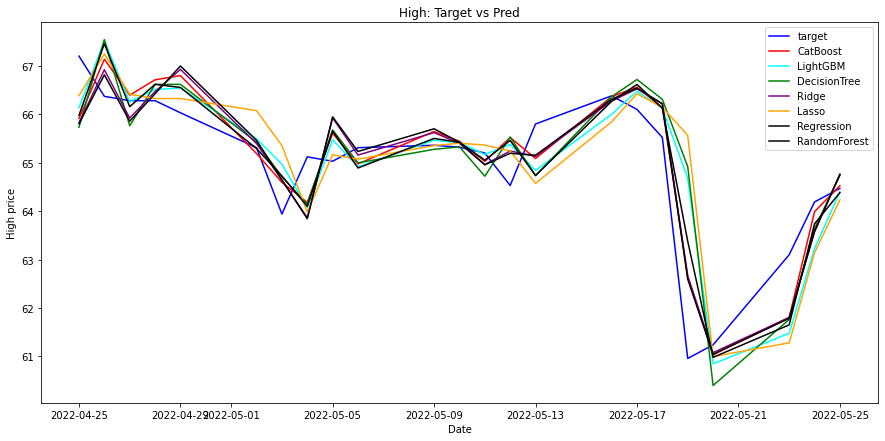

In [55]:
plt.figure(figsize=(15, 7))
plt.plot(preds['High']['High'].loc['2022-04-23':'2022-05-25'], label='target', color='b')
plt.plot(preds['High']['CatBoostRegressor'].loc['2022-04-23':'2022-05-25'], label='CatBoost', color='red')
plt.plot(preds['High']['LGBMRegressor'].loc['2022-04-23':'2022-05-25'], label='LightGBM', color='cyan')
plt.plot(preds['High']['DecisionTreeRegressor'].loc['2022-04-23':'2022-05-25'], label='DecisionTree', color='green')
plt.plot(preds['High']['LinearRegression_ridge'].loc['2022-04-23':'2022-05-25'], label='Ridge', color='purple')
plt.plot(preds['High']['LinearRegression_lasso'].loc['2022-04-23':'2022-05-25'], label='Lasso', color='orange')
plt.plot(preds['High']['LinearRegression'].loc['2022-04-23':'2022-05-25'], label='Regression', color='black')
plt.plot(preds['High']['RandomForestRegressor'].loc['2022-04-23':'2022-05-25'], label='RandomForest', color='black')
plt.title('High: Target vs Pred')
plt.ylabel('High price')
plt.xlabel('Date')
plt.legend()
plt.show()

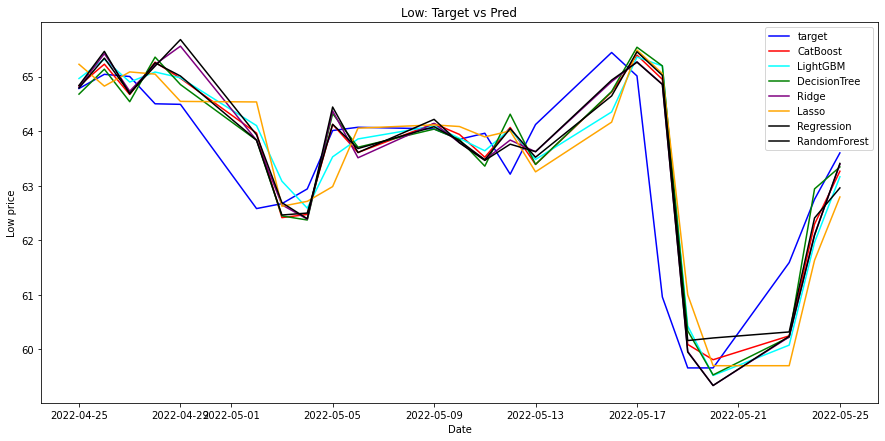

In [56]:
plt.figure(figsize=(15, 7))
plt.plot(preds['Low']['Low'].loc['2022-04-23':'2022-05-25'], label='target', color='b')
plt.plot(preds['Low']['CatBoostRegressor'].loc['2022-04-23':'2022-05-25'], label='CatBoost', color='red')
plt.plot(preds['Low']['LGBMRegressor'].loc['2022-04-23':'2022-05-25'], label='LightGBM', color='cyan')
plt.plot(preds['Low']['DecisionTreeRegressor'].loc['2022-04-23':'2022-05-25'], label='DecisionTree', color='green')
plt.plot(preds['Low']['LinearRegression_ridge'].loc['2022-04-23':'2022-05-25'], label='Ridge', color='purple')
plt.plot(preds['Low']['LinearRegression_lasso'].loc['2022-04-23':'2022-05-25'], label='Lasso', color='orange')
plt.plot(preds['Low']['LinearRegression'].loc['2022-04-23':'2022-05-25'], label='Regression', color='black')
plt.plot(preds['Low']['RandomForestRegressor'].loc['2022-04-23':'2022-05-25'], label='RandomForest', color='black')
plt.title('Low: Target vs Pred')
plt.ylabel('Low price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [57]:
dtr_df = pd.DataFrame(trading(preds['High']['DecisionTreeRegressor'], preds['Low']['DecisionTreeRegressor'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
rf_df = pd.DataFrame(trading(preds['High']['RandomForestRegressor'], preds['Low']['RandomForestRegressor'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
reg_l_df = pd.DataFrame(trading(preds['High']['LinearRegression_lasso'], preds['Low']['LinearRegression_lasso'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
reg_r_df = pd.DataFrame(trading(preds['High']['LinearRegression_ridge'], preds['Low']['LinearRegression_ridge'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
lgb_df = pd.DataFrame(trading(preds['High']['LGBMRegressor'], preds['Low']['LGBMRegressor'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
cb_df = pd.DataFrame(trading(preds['High']['CatBoostRegressor'], preds['Low']['CatBoostRegressor'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))

In [58]:
dtr_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
2146,failed,64.309546,64.510002,0.200456,7.649858,354,1793
2147,failed,65.536543,65.779999,0.243456,7.893314,354,1794
2148,failed,65.194950,61.200001,-3.994949,3.898365,354,1795
2149,failed,60.339677,60.000000,-0.339677,3.558688,354,1796
2150,success,62.940676,63.639544,0.698869,4.257557,355,1796


In [59]:
rf_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
2197,failed,64.044225,64.510002,0.465777,15.363312,278,1920
2198,failed,65.453484,65.779999,0.326515,15.689827,278,1921
2199,failed,65.021131,61.200001,-3.821131,11.868697,278,1922
2200,failed,60.161374,60.000000,-0.161374,11.707323,278,1923
2201,success,60.208813,60.981933,0.773120,12.480442,279,1923


In [60]:
reg_l_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
2505,failed,64.003374,64.510002,0.506629,12.038016,505,2001
2506,failed,65.484381,65.779999,0.295618,12.333634,505,2002
2507,failed,65.054089,61.200001,-3.854088,8.479546,505,2003
2508,failed,61.001339,60.000000,-1.001339,7.478207,505,2004
2509,success,59.700458,61.000513,1.300054,8.778262,506,2004


In [61]:
reg_r_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
2276,failed,64.141250,64.610001,0.468750,26.738743,338,1939
2277,failed,63.835655,64.510002,0.674347,27.413090,338,1940
2278,failed,65.269665,65.779999,0.510333,27.923424,338,1941
2279,failed,64.857963,61.200001,-3.657962,24.265461,338,1942
2280,failed,59.961404,60.000000,0.038596,24.304057,338,1943


In [62]:
lgb_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
2292,failed,63.867269,64.010002,0.142733,23.061327,360,1933
2293,failed,64.035362,64.510002,0.474640,23.535967,360,1934
2294,failed,65.356293,65.779999,0.423706,23.959674,360,1935
2295,failed,65.193612,61.200001,-3.993611,19.966062,360,1936
2296,failed,60.428294,60.000000,-0.428294,19.537768,360,1937


In [63]:
cb_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
2167,failed,64.066511,64.510002,0.443491,16.974746,289,1879
2168,failed,65.392076,65.779999,0.387923,17.362668,289,1880
2169,failed,64.947952,61.200001,-3.747951,13.614717,289,1881
2170,failed,60.090074,60.000000,-0.090074,13.524643,289,1882
2171,success,59.809792,61.035758,1.225966,14.750609,290,1882
